In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, accumulate
import os
import sys
import pathlib
import time
import plotly.graph_objects as go
import plotly.express as px
from tqdm.notebook import tqdm

In [3]:
def load_input(file_name):
  X = []
  y = []
  waters = []
  houses = []
  S = []
  with open(file_name, "r") as f:
    s = iter(f.read().split("\n"))
    N, W, K, C = map(int, next(s).split())
    for i in range(N):
      ss = list(map(int, next(s).split()))
      S.append(ss)
      for j in range(N):
        X.append([i, j])
        y.append(np.log10(ss[j]))
    for i in range(W):
      waters.append(tuple(map(int, next(s).split())))
    for j in range(K):
      houses.append(tuple(map(int, next(s).split())))
  
  return N, W, K, C, S, waters, houses, X, y


class UnionFind:
  def __init__(self, n):
    self.sz: int = n
    self.par = [-1 for _ in range(n)]

  def same(self, a: int, b: int) -> bool :
    return self.leader(a) == self.leader(b)

  def leader(self, a: int) -> int:
    if self.par[a] == -1:
      return a
    p = self.leader(self.par[a])
    self.par[a] = p
    return p

  def merge(self, a: int, b: int):
    pa = self.leader(a)
    self.par[pa] = self.leader(b)


# baseline solve

In [4]:
def solve(N, W, K, C, sources, houses, DEBUG=True):
  pos = sources + houses
  dists = []
  for i in range(W+K):
    for j in range(i):
      dist = (pos[i][0]-pos[j][0])**2+(pos[i][1]-pos[j][1])**2
      dists.append((dist, j, i))
  dists.sort()
  uf = UnionFind(N)
  boss = [-1] * (W+K)
  edges = []
  for t in dists:
    dist, i, j = t
    if uf.same(i, j) or (i < W and j < W):
      continue
    if i < W and boss[j] != -1:
      continue
    uf.merge(i, j)
    edges.append((i, j))
    for w in range(W):
      for k in range(K):
        if uf.same(w, k+W):
          boss[W+k] = w
    check = True
    for k in range(W, W + K):
      if boss[k] == -1:
        check = False
        break
    if check:
      break

  M = len(edges)  
  L = 10**18
  ans_grid = None
  def fill(ps, pt, g):
    if ps[0] == pt[0]:
      for j in range(min(ps[1], pt[1]), max(ps[1], pt[1]) + 1):
        g[ps[0]][j] = 1
    else:
      for i in range(min(ps[0], pt[0]), max(ps[0], pt[0]) + 1):
        g[i][ps[1]] = 1

      
  for i in range(1<<M):
    l = 0
    grid = np.zeros((N, N))
    for j, edge in enumerate(edges):
      s, t = edge
      ps = pos[s]
      pt = pos[t]
      if (1 << j) & i:
        pu = (pt[0], ps[1])
      else:
        pu = (ps[0], pt[1])
        
      fill(ps, pu, grid)
      fill(pu, pt, grid)

    l = np.sum(grid)
    if l < L:
      L = l
      ans_grid = grid

  return ans_grid


import heapq

di = [0, 1, 0, -1]
dj = [1, 0, -1, 0]

def is_out(i, j, N):
  return (i < 0 or j < 0 or i >= N or j >= N)

def dijkstra_heap(start, goal, S, C):
    # startから各頂点への最短距離を格納するリスト
    N = len(S)
    dist = [[float('inf') for _ in range(N)] for _ in range(N)]
    pre = [[(-1, -1) for _ in range(N)] for _ in range(N)]
    ci, cj = start
    dist[ci][cj] = 0
    pre[ci][cj] = start
    # ヒープに(startからの距離, 頂点)のタプルを追加
    heap = [(0, start)]

    while heap:
        d, c = heapq.heappop(heap)
        ci, cj = c
        if dist[ci][cj] < d or dist[goal[0]][goal[1]] < d:
            continue
        # 隣接する頂点を更新
        for d in range(4):
            ni = ci + di[d]
            nj = cj + dj[d]
            if is_out(ni, nj, N):
              continue
            w = S[ni][nj] + C
            if dist[ni][nj] > dist[ci][cj] + w:
                dist[ni][nj] = dist[ci][cj] + w
                heapq.heappush(heap, (dist[ni][nj], (ni, nj)))
                pre[ni][nj] = c
    return dist, pre

def dijkstra_heap_update(start, goal, S, C, mst):
    # startから各頂点への最短距離を格納するリスト
    N = len(S)
    dist = [[float('inf') for _ in range(N)] for _ in range(N)]
    pre = [[(-1, -1) for _ in range(N)] for _ in range(N)]
    ci, cj = start
    dist[ci][cj] = 0
    pre[ci][cj] = start
    # ヒープに(startからの距離, 頂点)のタプルを追加
    heap = [(0, start)]

    while heap:
        d, c = heapq.heappop(heap)
        ci, cj = c
        if dist[ci][cj] < d or dist[goal[0]][goal[1]] < d:
            continue
        # 隣接する頂点を更新
        for d in range(4):
            ni = ci + di[d]
            nj = cj + dj[d]
            if is_out(ni, nj, N):
              continue
            w = S[ni][nj] + C if mst[ni][nj] == 0 else 0
            if dist[ni][nj] > dist[ci][cj] + w:
                dist[ni][nj] = dist[ci][cj] + w
                heapq.heappush(heap, (dist[ni][nj], (ni, nj)))
                pre[ni][nj] = c
    return dist, pre



def calc_best(N, W, K, C, S, sources, houses, DEBUG=True):
  pos = sources + houses
  dists = []
  for i in range(W+K):
    for j in range(i):
      p1 = sources[i] if i < W else houses[i-W]
      p2 = sources[j] if j < W else houses[j-W]
      dist, _ = dijkstra_heap(p1, p2, S, C)
      dists.append((dist[p2[0]][p2[1]], j, i))
  dists.sort()
  uf = UnionFind(N)
  boss = [-1] * (W+K)
  edges = []
  for t in dists:
    dist, i, j = t
    if uf.same(i, j) or (i < W and j < W):
      continue
    if i < W and boss[j] != -1:
      continue
    if boss[i] != -1 and boss[j] != -1 and boss[i] != boss[j]:
      continue
    uf.merge(i, j)
    edges.append((i, j))
    for w in range(W):
      for k in range(K):
        if uf.same(w, k+W):
          boss[W+k] = w
    check = True
    for k in range(W, W + K):
      if boss[k] == -1:
        check = False
        break
    if check:
      break

  mst = [[0 for _ in range(N)] for _ in range(N)]
  for edge in edges:
    v1, v2 = edge
    p1 = sources[v1] if v1 < W else houses[v1-W]
    p2 = sources[v2] if v2 < W else houses[v2-W]
    dist, pre = dijkstra_heap(p1, p2, S, C)
    cur = p2
    while True:
      i, j = cur
      mst[i][j] += 1
      if pre[i][j] == cur:
        break
      cur = pre[i][j]
    

  for edge in edges:
    v1, v2 = edge
    p1 = sources[v1] if v1 < W else houses[v1-W]
    p2 = sources[v2] if v2 < W else houses[v2-W]
    dist, pre = dijkstra_heap(p1, p2, S, C)
    cur = p2
    while True:
      i, j = cur
      
      mst[i][j] -= 1
      if pre[i][j] == cur:
        break
      cur = pre[i][j]
    
    
    dist, pre2 = dijkstra_heap_update(p1, p2, S, C, mst)
    cur = p2
    while True:
      i, j = cur
      mst[i][j] += 1
      if pre2[i][j] == cur:
        break
      cur = pre2[i][j]

  
  return mst

In [103]:
file_name = "in/default/0000.txt"
N, W, K, C, S, sources, houses, X, y = load_input(file_name=file_name)
mst = calc_best(N, W, K, C, S, sources, houses)


# visualize heatmap

2


C:\Users\81903\AppData\Local\Temp\ipykernel_18224\1520191954.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


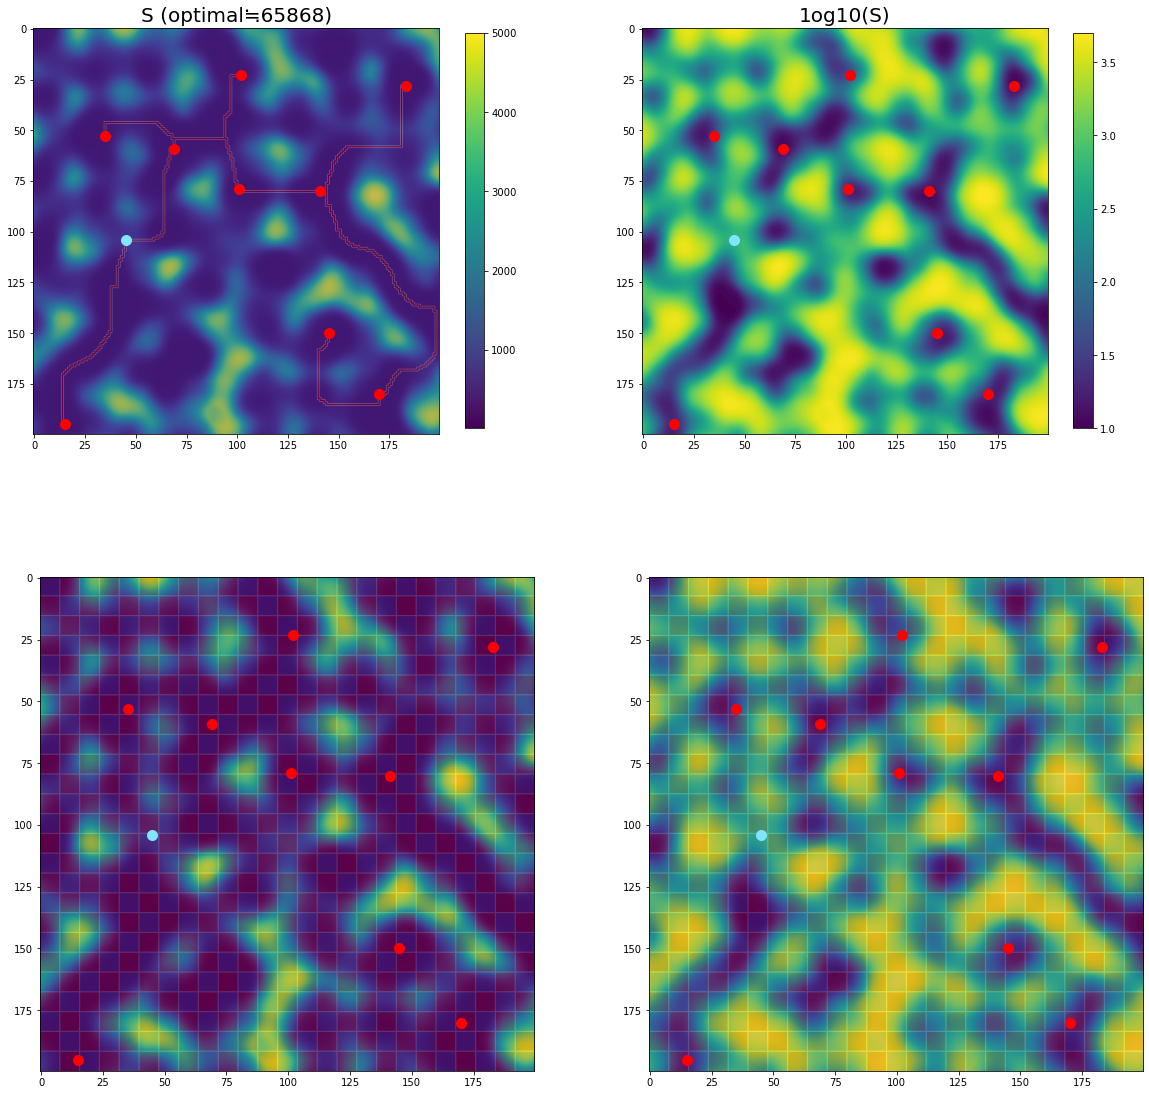

In [50]:
file_name = "./in/default/0000.txt"

N, W, K, C, S, sources, houses, X, y = load_input(file_name)
print(C)
S = np.array(S)
mst_best = calc_best(N, W, K, C, S, sources, houses)
mst = [[mst_best[i][j] > 0 for j in range(N)] for i in range(N)]
mst_score = 0
for i in range(N):
  for j in range(N):
    if mst_best[i][j] > 0:
      mst_score += C + S[i][j]

pattern = np.zeros((200, 200))
for i in range(200):
  for j in range(200):
    if ((i // 8) % 2 + (j // 8) % 2) % 2 == 0:
      pattern[i, j] = 0
    else:
      pattern[i, j] = 1
      
  
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
im1 = axes[0][0].imshow(S.reshape(N, N), vmin=10, vmax=5000)
im2 = axes[0][1].imshow(np.log10(S).reshape(N,N), vmin=1, vmax=np.log10(5000))
axes[1][0].imshow(S.reshape(N,N), vmin=1, vmax=5000)
axes[1][1].imshow(np.log10(S).reshape(N,N), vmin=1, vmax=np.log10(5000))

axes[0][0].set_title(f"S (optimal≒{mst_score})", fontsize=20)
axes[0][1].set_title("1og10(S)", fontsize=20)
axes[0][0].imshow(mst, cmap="coolwarm", alpha=0.3)
axes[1][0].imshow(pattern, cmap="coolwarm", alpha=0.2)
axes[1][1].imshow(pattern, cmap="coolwarm", alpha=0.2)

for source in sources:
  i, j = source
  axes[0][0].plot(j, i, c=(0.5, 0.9, 1), marker="o", markersize=10)
  axes[0][1].plot(j, i, c=(0.5, 0.9, 1), marker="o", markersize=10)
  axes[1][0].plot(j, i, c=(0.5, 0.9, 1), marker="o", markersize=10)
  axes[1][1].plot(j, i, c=(0.5, 0.9, 1), marker="o", markersize=10)
  
for house in houses:
  i, j = house
  axes[0][0].plot(j, i, "ro", markersize=10)
  axes[0][1].plot(j, i, "ro", markersize=10)
  axes[1][0].plot(j, i, "ro", markersize=10)
  axes[1][1].plot(j, i, "ro", markersize=10)


fig.colorbar(im1, ax=axes[0][0], shrink=0.8)
fig.colorbar(im2, ax=axes[0][1], shrink=0.8)


fig.show()

# test case generation using toolkit

In [2]:
# C = [1, 2, 4, 8, 16, 32, 64, 128]
# W = [1, 2, 3, 4]
# K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# num_seed = 20
# output_path = pathlib.Path("./out")
# input_path = pathlib.Path("./in")
# for c, w, k in product(C, W, K):
#   in_path = input_path / f"C{c}/W{w}/K{k}"
#   out_path = out_path / f"C{c}/W{w}/K{k}"
#   in_path.mkdir(parents=True)
#   out_path.mkdir(parents=True)

NameError: name 'out_path' is not defined

In [ ]:
def generate_S(seed):
  np.random.seed(seed=seed)
  pass

# simulated annealing for initial tree

In [2]:
import platform
s = platform.system()

In [9]:
os.system("cat in\\C1\\W2\\K4\\0000.txt | .\\bin\\sa")

255

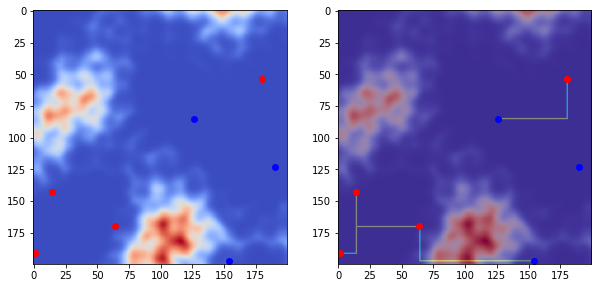

In [55]:
file_name = "in/default/0016.txt"
N, W, K, C, S, sources, houses, X, y = load_input(file_name=file_name)
ans_grid = solve(N, W, K, C, sources, houses)


fig, axes = plt.subplots(ncols=2, figsize=(10, 20))
axes[0].imshow(S, cmap="coolwarm")
axes[1].imshow(S, cmap="coolwarm")
axes[1].imshow(ans_grid, alpha=0.4)

for source in sources:
  i, j = source
  axes[0].plot(j, i, "bo")
  axes[1].plot(j, i, "bo")
for house in houses:
  i, j = house
  axes[0].plot(j, i, "ro")
  axes[1].plot(j, i, "ro")

plt.show()

# gaussian process prediction precision

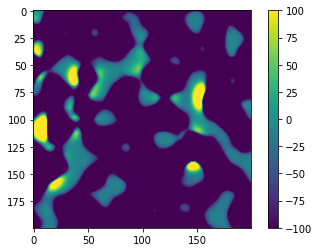

In [10]:
file_name = "./out/gp/sample_out.txt"
heat = []
rect = lambda x: 100 if float(x) > 100 else -100 if float(x) < -100 else float(x)
with open(file_name, "r") as f:
  lines = f.readlines()
  for line in lines:
    line = list(map(rect, line.strip().split()))
    heat.append(line)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
mappable = ax.imshow(heat)
fig.colorbar(mappable)
plt.show()

# model check

In [24]:
import sklearn
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cluster import K
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error


SCORE kernel ridge      MSE: 3.90, MAE: 1.83
SCORE gaussian process  MSE: 0.81, MAE: 0.64


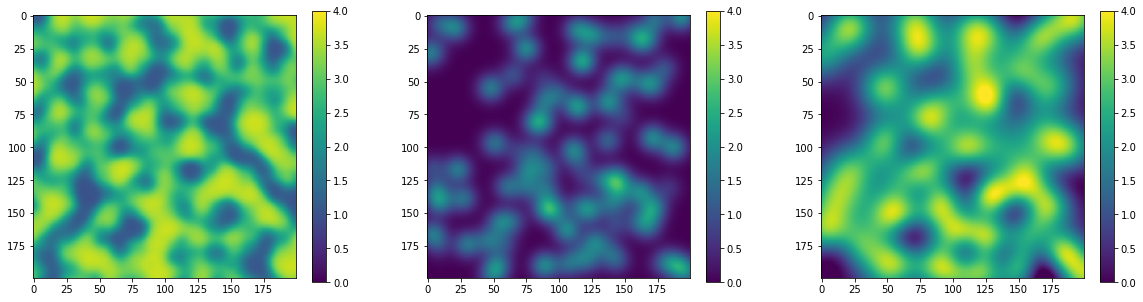

In [68]:
file_name = "./in/default/0000.txt"
num_sample = 100

X = []
y = []

with open(file_name, "r") as f:
  s = iter(f.read().split("\n"))
  N, W, K, C = map(int, next(s).split())
  for i in range(N):
    ss = list(map(int, next(s).split()))
    for j in range(N):
      X.append([i, j])
      y.append(ss[j])

X = np.array(X)
y = np.log10(np.array(y))
idx_sample = np.random.choice(200 * 200, num_sample, replace=False)
X_sample = X[idx_sample]
y_sample = y[idx_sample]
kernel = RBF(length_scale=5)
kr = KernelRidge(kernel="rbf", gamma=0.01)
gp = GaussianProcessRegressor(kernel=kernel)
kr.fit(X_sample, y_sample)
gp.fit(X_sample, y_sample)
pred_kr = kr.predict(X)
pred_gp = gp.predict(X)
mse_kr = mean_squared_error(y, pred_kr)
mse_gp = mean_squared_error(y, pred_gp)
mae_kr = mean_absolute_error(y, pred_kr)
mae_gp = mean_absolute_error(y, pred_gp)
print(f"SCORE kernel ridge      MSE: {mse_kr:3.2f}, MAE: {mae_kr:3.2f}")
print(f"SCORE gaussian process  MSE: {mse_gp:3.2f}, MAE: {mae_gp:3.2f}")
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))
im1 = axes[0].imshow(y.reshape(N, N), vmin=0, vmax=4)
im2 = axes[1].imshow(pred_kr.reshape(N,N), vmin=0, vmax=4)
im3 = axes[2].imshow(pred_gp.reshape(N, N), vmin=0, vmax=4)

fig.colorbar(im1, ax=axes[0], shrink=0.5)
fig.colorbar(im2, ax=axes[1], shrink=0.5)
fig.colorbar(im3, ax=axes[2], shrink=0.5)

vmin = min(im1.get_clim()[0], im2.get_clim()[0], im3.get_clim()[0])
vmax = max(im1.get_clim()[1], im2.get_clim()[1], im3.get_clim()[1])

im1.set_clim(vmin, vmax)
im2.set_clim(vmin, vmax)
im3.set_clim(vmin, vmax)
plt.show()

Init Done
Found MST
Got train data


Found mst: 16


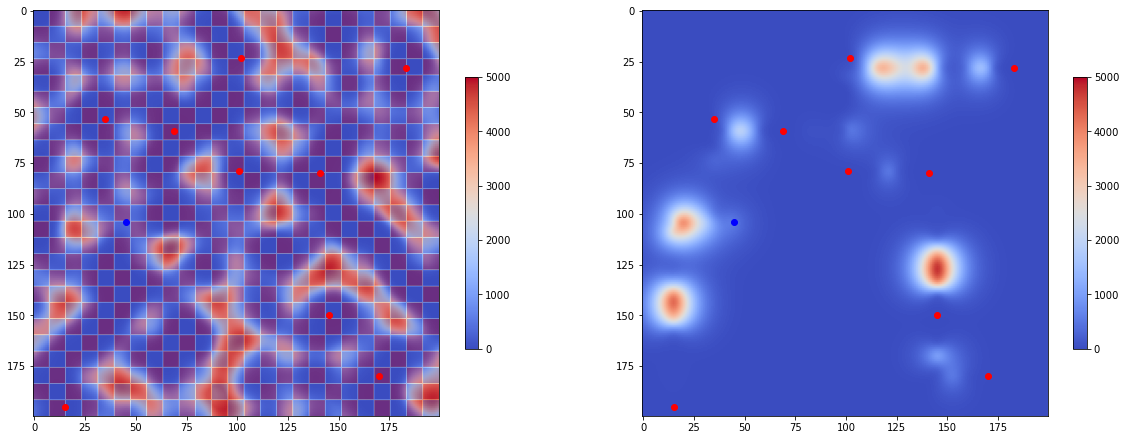

sample predict: 0.0852291784295407, 96.52463303241063, 0.23552212541585266
train done


In [4]:
# # memo
# C++のboostのLU分解で逆行列を求める関数を作ったが、
# numpy.linalg.invより遅すぎたのでPythonを使ってみようと思う。
# (200*200の行列の逆行列計算で、C++: 603ms, Python: 110ms @atcoder code test)
# boostのublasの線形代数演算が遅すぎるのだろうか。
# 
# ガウス過程回帰を使う。

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
import time
import sys
from itertools import product

GRID_SIZE = 8
DEBUG = True
if DEBUG:
  import matplotlib.pyplot as plt

start_time = None
cur_time = None

def plot_pred(y, pred, sources, houses, ans_grid):
  fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
  pattern = np.zeros((200, 200))
  for i in range(200):
    for j in range(200):
      if ((i // GRID_SIZE) % 2 + (j // GRID_SIZE) % 2) % 2 == 0:
        pattern[i, j] = 0
      else:
        pattern[i, j] = 1
      
  for source in sources:
    i, j = source
    axes[0].plot(j, i, "bo")
    axes[1].plot(j, i, "bo")
  for house in houses:
    i, j = house
    axes[0].plot(j, i, "ro")
    axes[1].plot(j, i, "ro")


  im1 = axes[0].imshow(y, vmin=0, vmax=5000, cmap="coolwarm")
  im2 = axes[1].imshow(pred, vmin=0, vmax=5000, cmap="coolwarm")
  # for grid in ans_grid:
  #  axes[0].imshow(grid, alpha=0.1, cmap="coolwarm")
  axes[0].imshow(pattern, alpha=0.4, cmap="coolwarm")
  fig.colorbar(im1, ax=axes[0], shrink=0.5)
  fig.colorbar(im2, ax=axes[1], shrink=0.5)

  vmin = min(im1.get_clim()[0], im2.get_clim()[0])
  vmax = max(im1.get_clim()[1], im2.get_clim()[1])

  im1.set_clim(vmin, vmax)
  im2.set_clim(vmin, vmax)

  plt.show()

def get_time():
  cur_time = time.time()
  return start_time - cur_time

def excavate(i: int, j: int, power: int):
  print(f"{i} {j} {power}", flush=True)
  return int(sys.stdin.readline().strip())
  
class UnionFind:
  def __init__(self, n):
    self.sz: int = n
    self.par = [-1] * n

  def same(self, a: int, b: int) -> bool :
    return self.leader(a) == self.leader(b)

  def leader(self, a: int) -> int:
    if self.par[a] == -1:
      return a
    p = self.leader(self.par[a])
    self.par[a] = p
    return p

  def merge(self, a: int, b: int):
    pa = self.leader(a)
    self.par[pa] = self.leader(b)


def solve(file_name):
  N, W, K, C, S, sources, houses, X, y = load_input(file_name=file_name)
  pos = sources + houses
  dists = []

  for i in range(W+K):
    for j in range(i):
      dist = abs(pos[i][0]-pos[j][0])+abs(pos[i][1]-pos[j][1])
      dists.append((dist, j, i))
  dists.sort()

  print("Init Done", file=sys.stderr)

  uf = UnionFind(N)
  boss = [-1] * (W+K)
  edges = []
  for t in dists:
    dist, i, j = t
    if uf.same(i, j) or (i < W and j < W):
      continue
    if i < W and boss[j] != -1:
      continue
    if boss[i] != -1 and boss[j] != -1 and boss[i] != boss[j]:
      continue
    uf.merge(i, j)
    edges.append((i, j))
    for w in range(W):
      for k in range(K):
        if uf.same(w, k+W):
          boss[W+k] = w

  M = len(edges)  
  L = 10**18
  ans_grid = []
  def fill(ps, pt, g):
    if ps[0] == pt[0]:
      for j in range(min(ps[1], pt[1]), max(ps[1], pt[1]) + 1):
        g[ps[0]][j] = 1
    else:
      for i in range(min(ps[0], pt[0]), max(ps[0], pt[0]) + 1):
        g[i][ps[1]] = 1

      
  for i in range(1<<M):
    l = 0
    grid = np.zeros((N, N), dtype=np.int8)
    for j, edge in enumerate(edges):
      s, t = edge
      ps = pos[s]
      pt = pos[t]
      if (1 << j) & i:
        pu = (pt[0], ps[1])
      else:
        pu = (ps[0], pt[1])
        
      fill(ps, pu, grid)
      fill(pu, pt, grid)

    l = np.sum(grid)
    if l < L:
      L = l
      ans_grid = []
      ans_grid.append(grid)
    elif l == L:
      ans_grid.append(grid)

  print("Found MST", file=sys.stderr)

  X_train = []
  y_train = []
  print(f"Found mst: {len(ans_grid)}")
  grid = ans_grid[0]
  for i in range(N):
    for j in range(N):
      if (i + j) % 3 == 0 and grid[i, j] == 1:
        res = 0
        power = max(C * 5, 10)
        total_power = (S[i][j] + power - 1) // power * power
        
        X_train.append((i, j))
        y_train.append(total_power - power / 2)
  
  print("Got train data", file=sys.stderr)
  
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  X_all = np.array([p for p in product(range(N), range(N))])
  kernel = Matern()
  gp = GaussianProcessRegressor(kernel=kernel)
  gp.fit(X_train, y_train)
  y_pred = gp.predict(X_all).reshape(N, N)
  
  plot_pred(S, y_pred, sources, houses, ans_grid)
  print(f"sample predict: {y_pred[20, 20]}, {y_pred[70, 29]}, {y_pred[169, 195]}", file=sys.stderr)
  print("train done", file=sys.stderr)

  return

  for i in range(N):
    for j in range(N):
      if (i + j) % 3 == 0 or ans_grid[i, j] == 0:
        continue

      pred = max(min(int(y_pred[i, j] + 10), 5000), 10)
      print(f"{i} {j} {pred}", file=sys.stderr)
      res = excavate(i, j, pred)
      if res == 2:
        print("All done", file=sys.stderr)
        return
      elif res == 1:
        continue
      elif res == -1:
        print("Invalid output", file=sys.stderr)
        exit(1)
      else: # res == 0
        power = C * 5
        while res == 0:
          res = excavate(i, j, power)


if __name__ == "__main__":
  file_name="./in/default/0000.txt"
  start_time = time.time()
  solve(file_name)

# histogram

In [21]:
file_name = "in/default/0010.txt"
N, W, K, C, S, sources, houses, X, y = load_input(file_name)
S = np.array(S).ravel()

trace = go.Histogram(
  x=S,
  xbins=dict(
    start=0,
    end=5000,
    size=20,
  )
)

layout = go.Layout(
    title='Histogram',  # グラフタイトル
    xaxis=dict(title='Value'),  # x軸のラベル
    yaxis=dict(title='Frequency')  # y軸のラベル
)

# ヒストグラムを描画
fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [33]:
n_grid = 200 * 200
n_file = 1000
n_split = 20
total = np.zeros(shape=n_split)

for i in range(n_file):
  file_name = f"./tools/in/{i:04d}.txt"
  n, w, k, c, S, sources, houses, x, y = load_input(file_name)
  S = np.array(S).ravel()
  S = np.sort(S)
  for j in range(n_split):
    total[j] += S[n_grid*(j+1) // n_split - 1]

print(total / n_file)

[  12.725   16.987   24.649   36.768   54.261   78.367  110.228  150.915
  201.924  265.822  347.822  455.572  600.399  797.144 1064.148 1425.909
 1911.76  2536.109 3294.434 5000.   ]


# calculate probalility

In [24]:
result = []
with open("./out/all5000/hist.txt", "r") as f:
  s = iter(f.readlines())
  h = []
  for line in s:
    line = line.strip()
    if "dist" in line:
      for _ in range(250):
        l = list(map(int, next(s).strip().split()))
        h.append(l)
      result.append(h)
      h = []

In [25]:
result = np.array(result)
result.shape

(10, 250, 250)

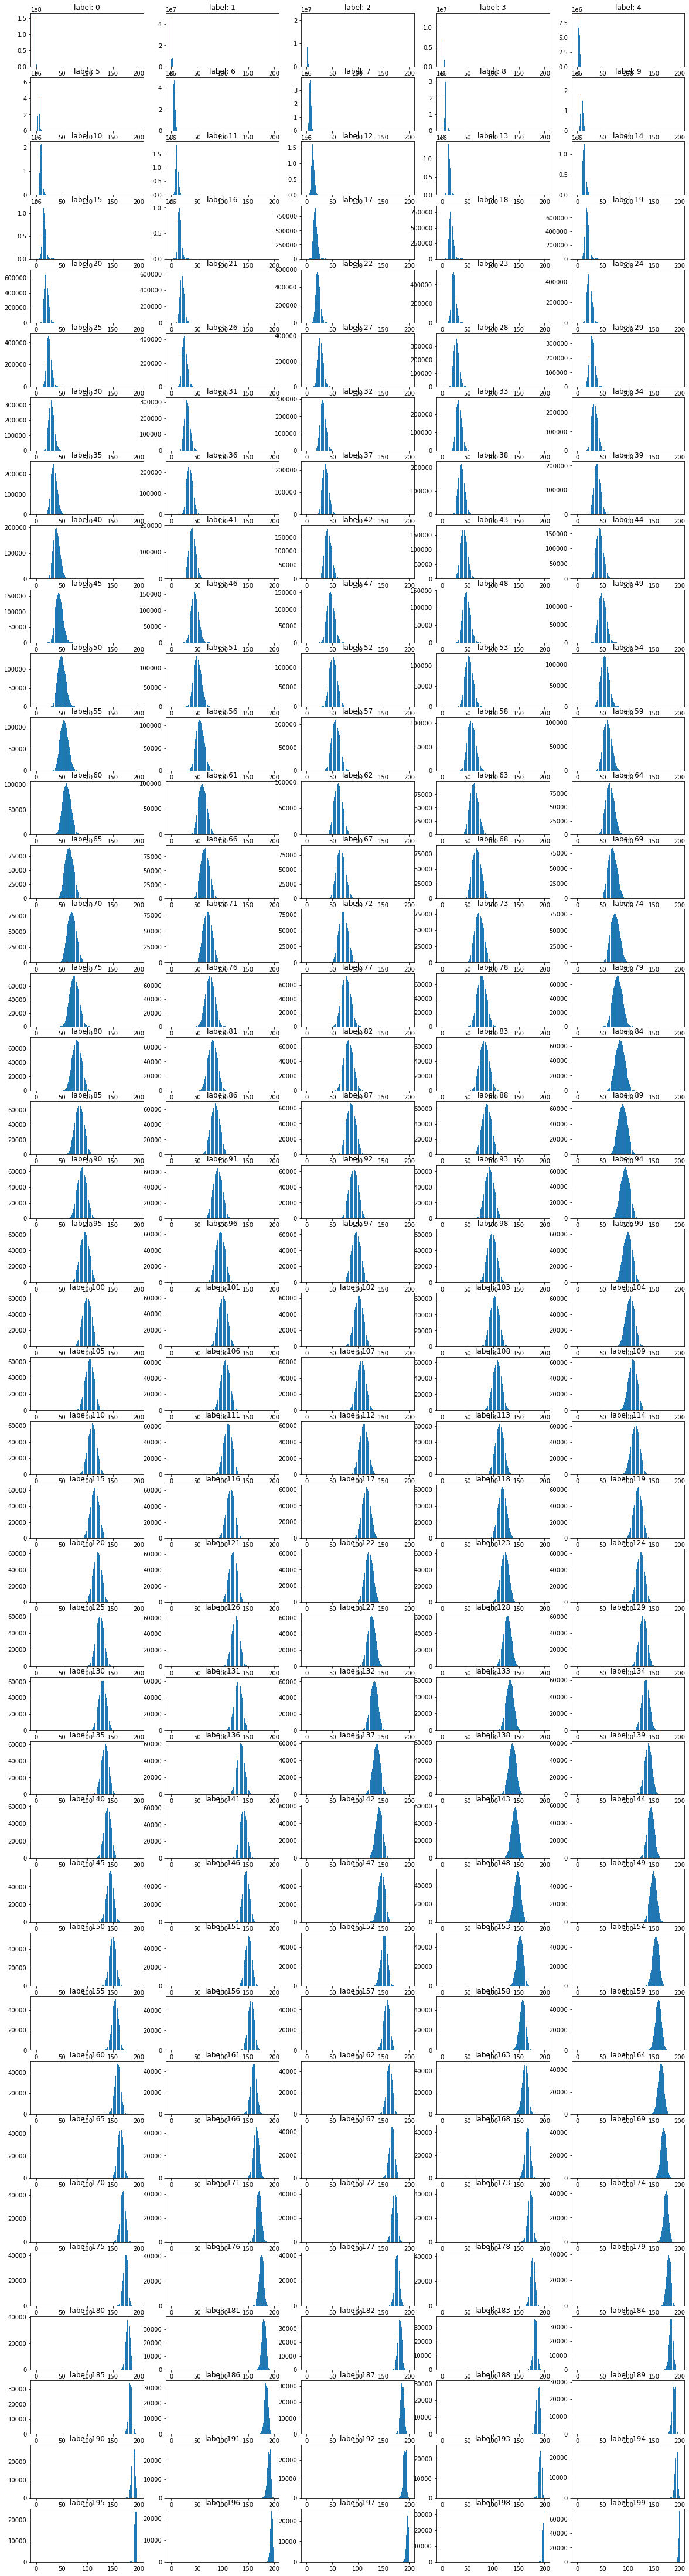

In [75]:
# distance = 1
fig, axes = plt.subplots(ncols=5, nrows=40, figsize=(20, 80))
for label in range(200):
  i = label // 5
  j = label % 5
  axes[i, j].bar(range(200), result[0][label])
  axes[i, j].set_title(f"label: {label}")

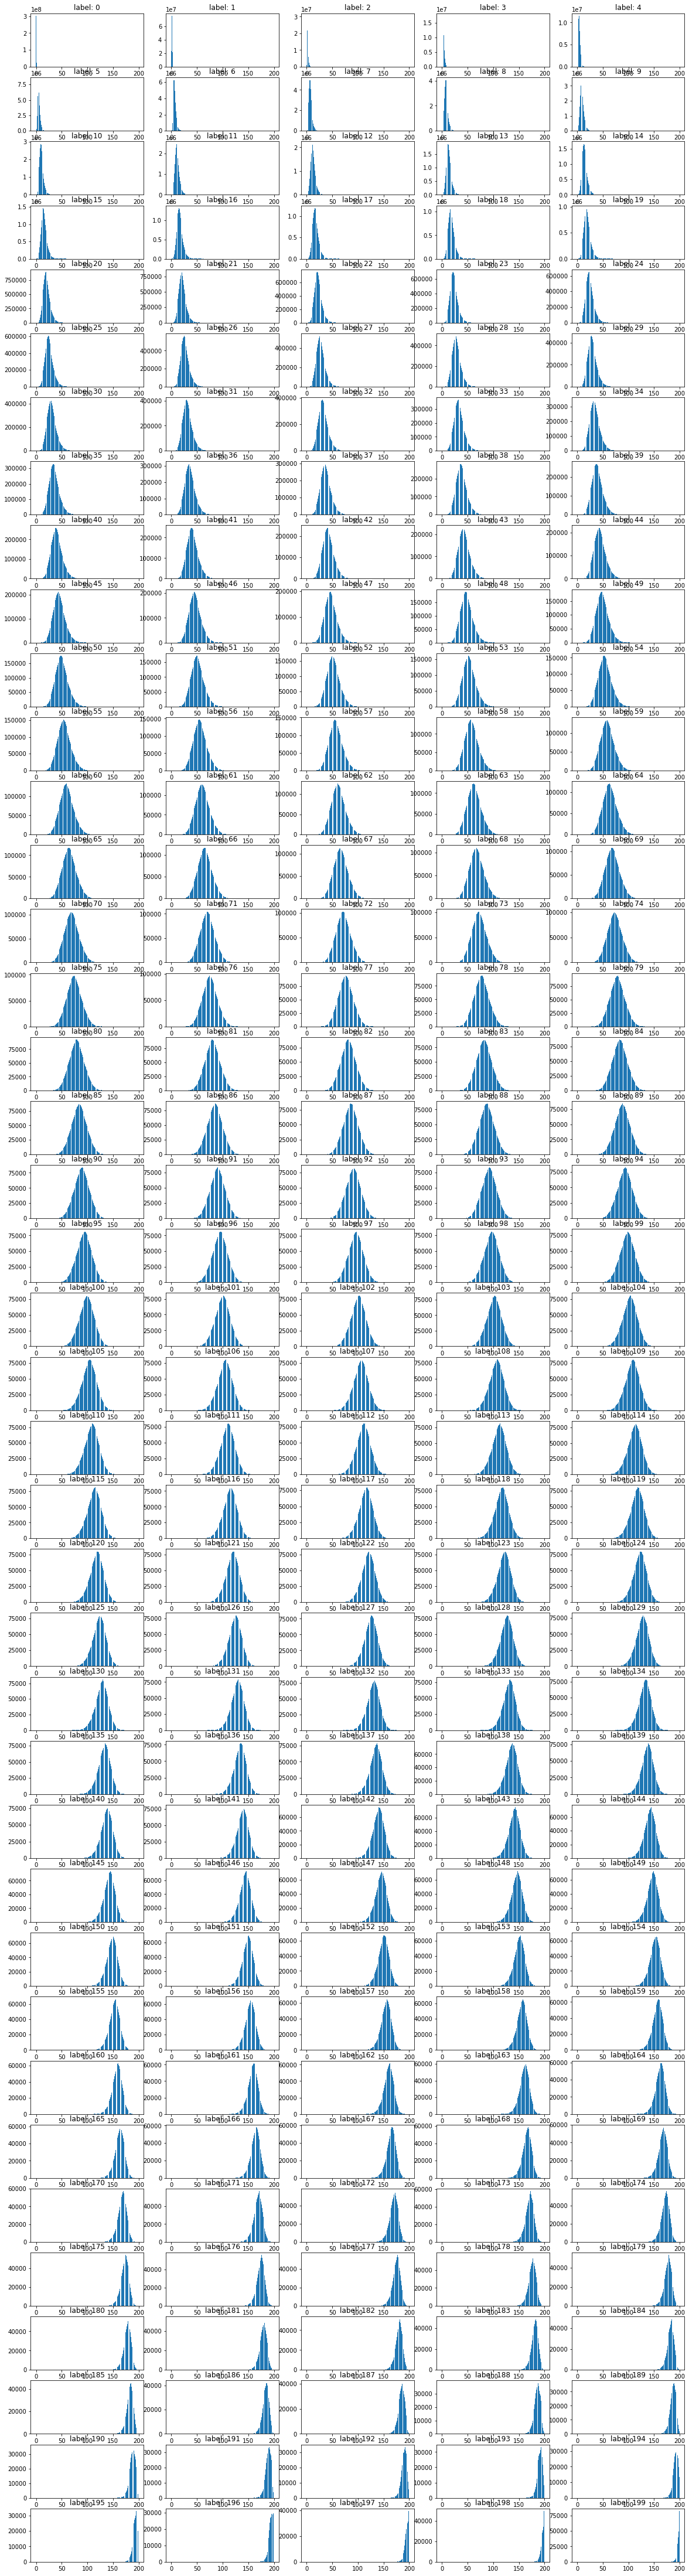

In [76]:
# distance = 2
fig, axes = plt.subplots(ncols=5, nrows=40, figsize=(20, 80))
for label in range(200):
  i = label // 5
  j = label % 5
  axes[i, j].bar(range(200), result[1][label])
  axes[i, j].set_title(f"label: {label}")

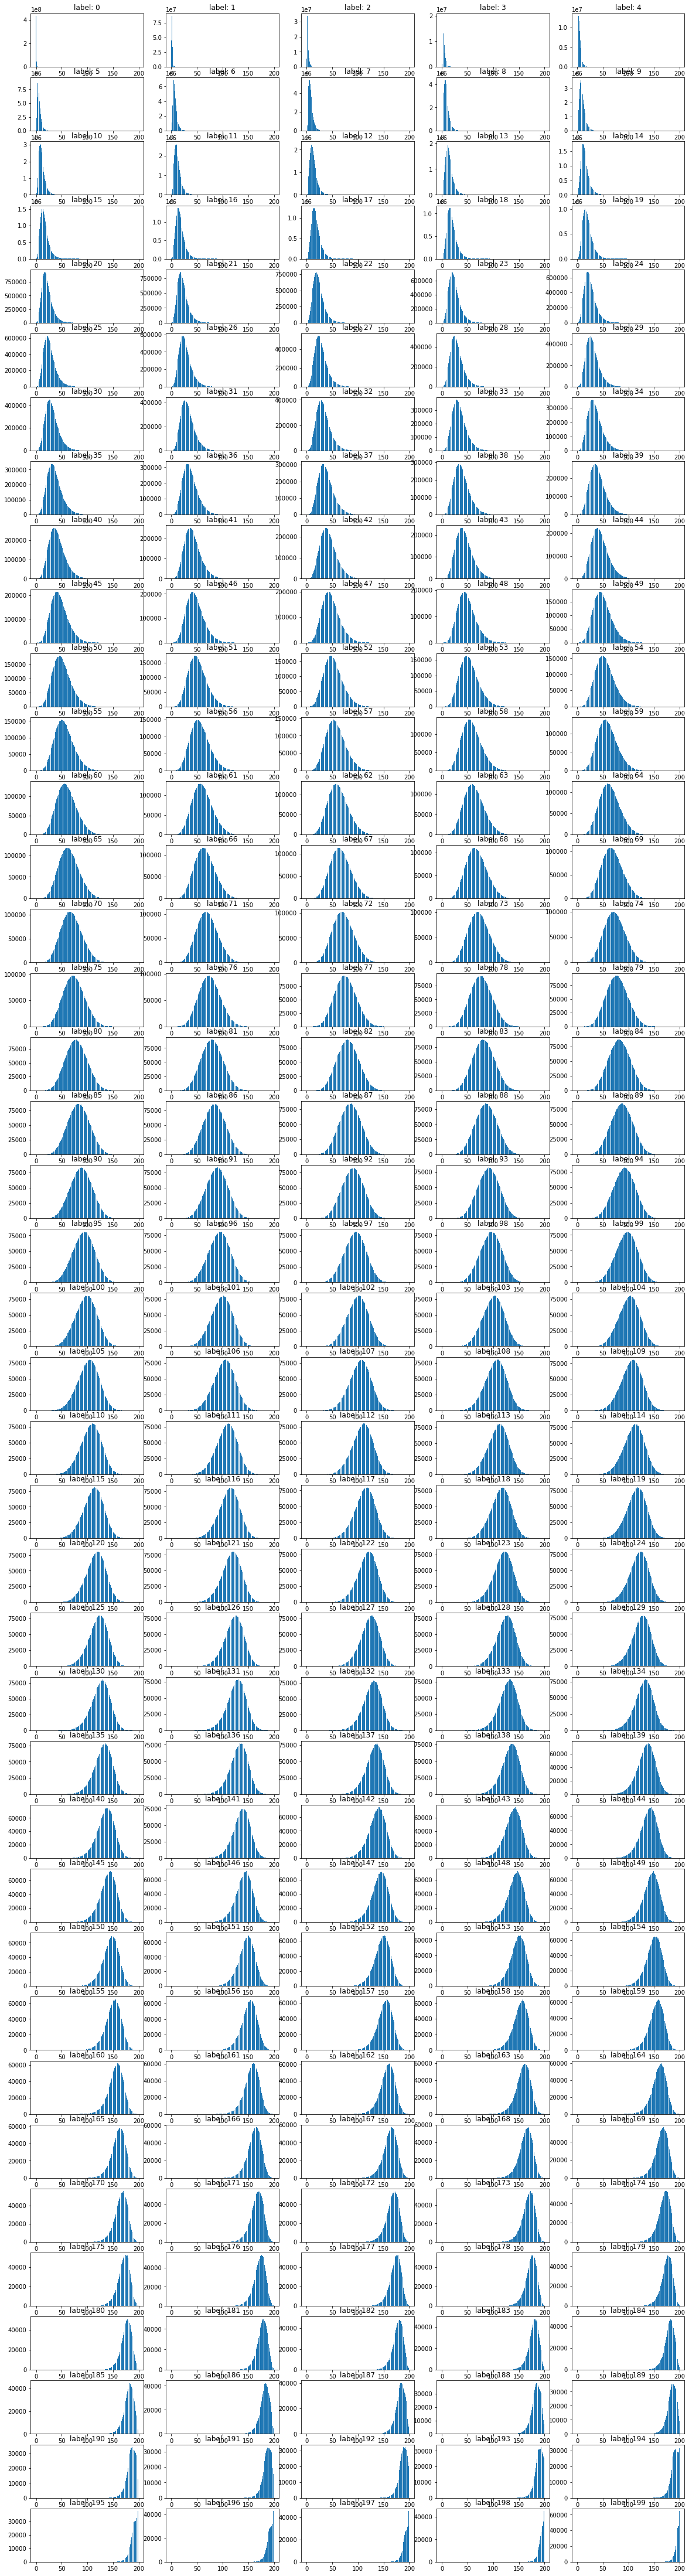

In [77]:
# distance = 3
fig, axes = plt.subplots(ncols=5, nrows=40, figsize=(20, 80))
for label in range(200):
  i = label // 5
  j = label % 5
  axes[i, j].bar(range(200), result[2][label])
  axes[i, j].set_title(f"label: {label}")

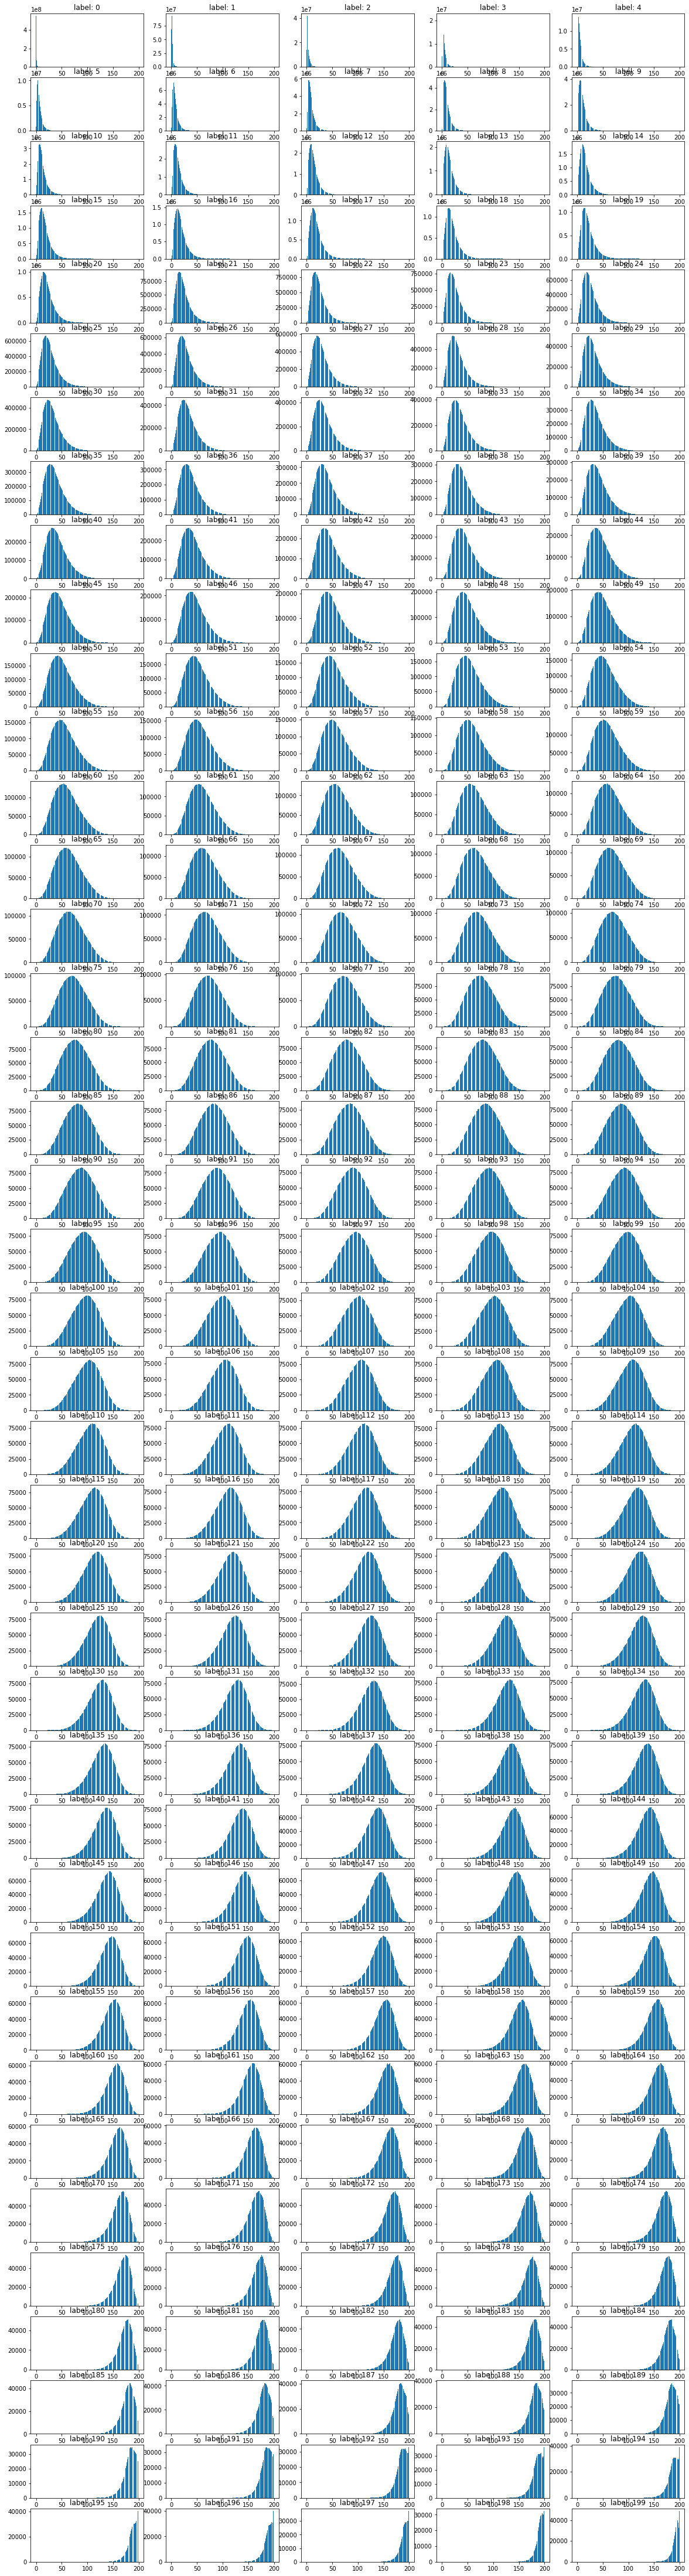

In [78]:
# distance = 4
fig, axes = plt.subplots(ncols=5, nrows=40, figsize=(20, 80))
for label in range(200):
  i = label // 5
  j = label % 5
  axes[i, j].bar(range(200), result[3][label])
  axes[i, j].set_title(f"label: {label}")

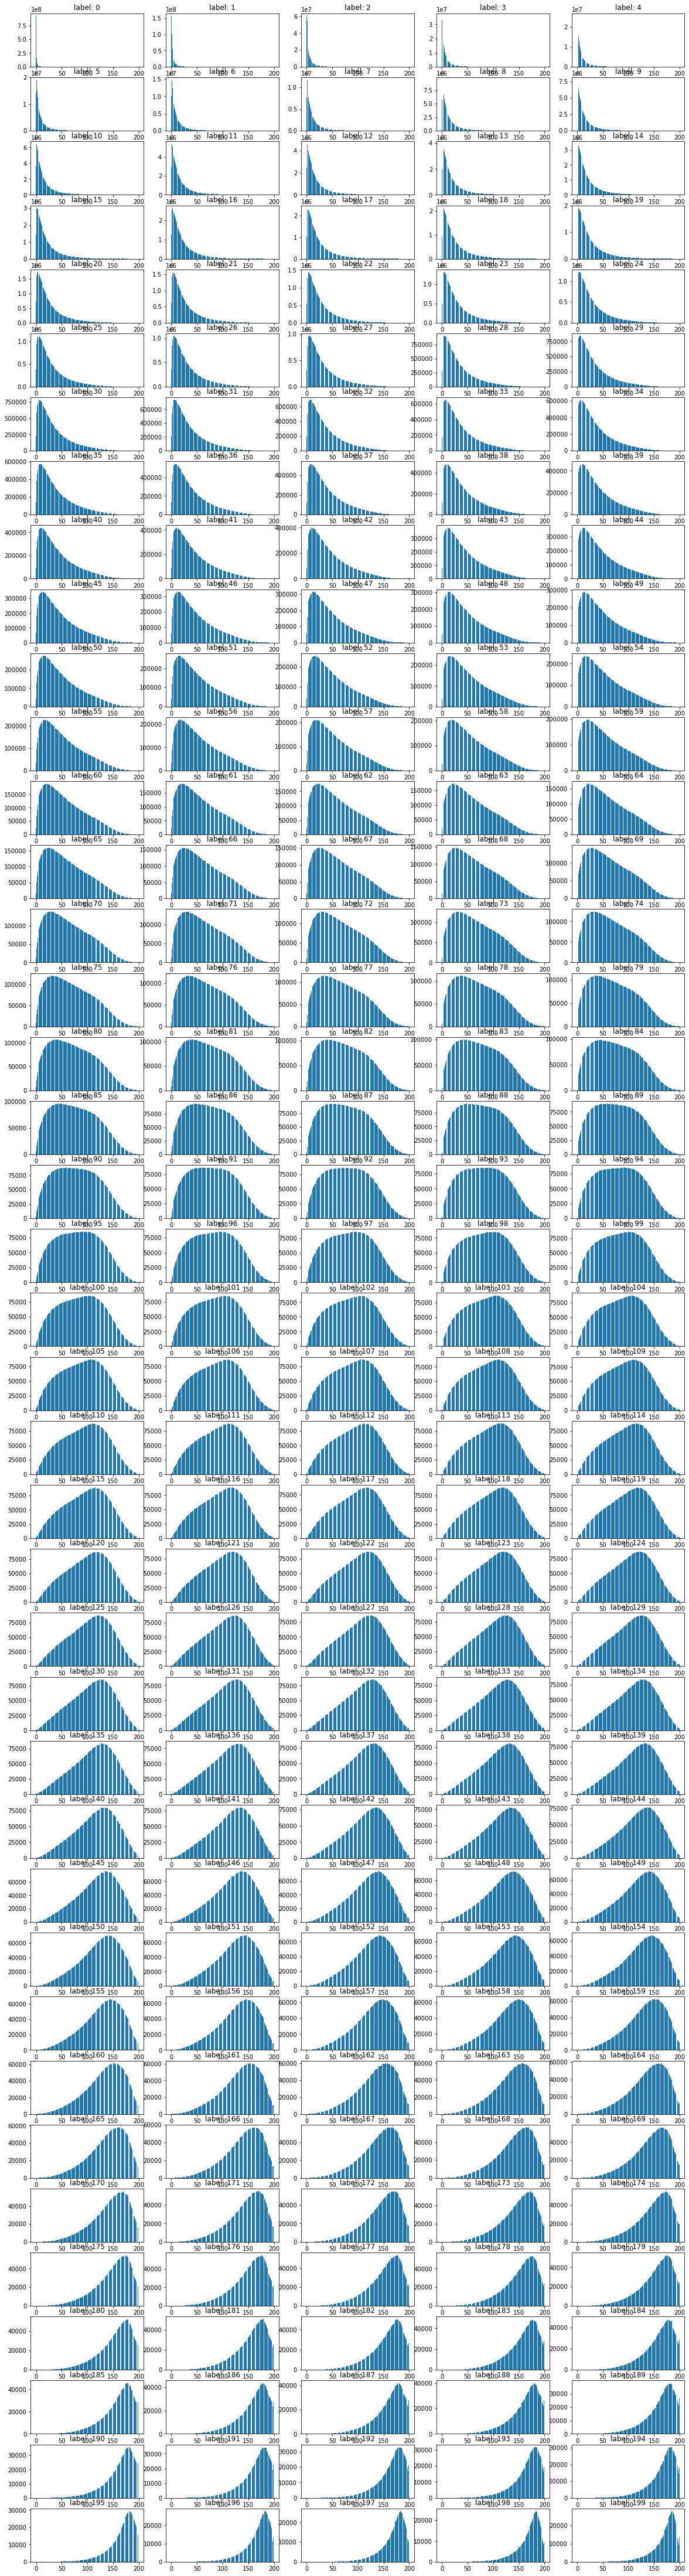

In [79]:
# distance = 8
fig, axes = plt.subplots(ncols=5, nrows=40, figsize=(20, 80))
for label in range(200):
  i = label // 5
  j = label % 5
  axes[i, j].bar(range(200), result[7][label])
  axes[i, j].set_title(f"label: {label}")

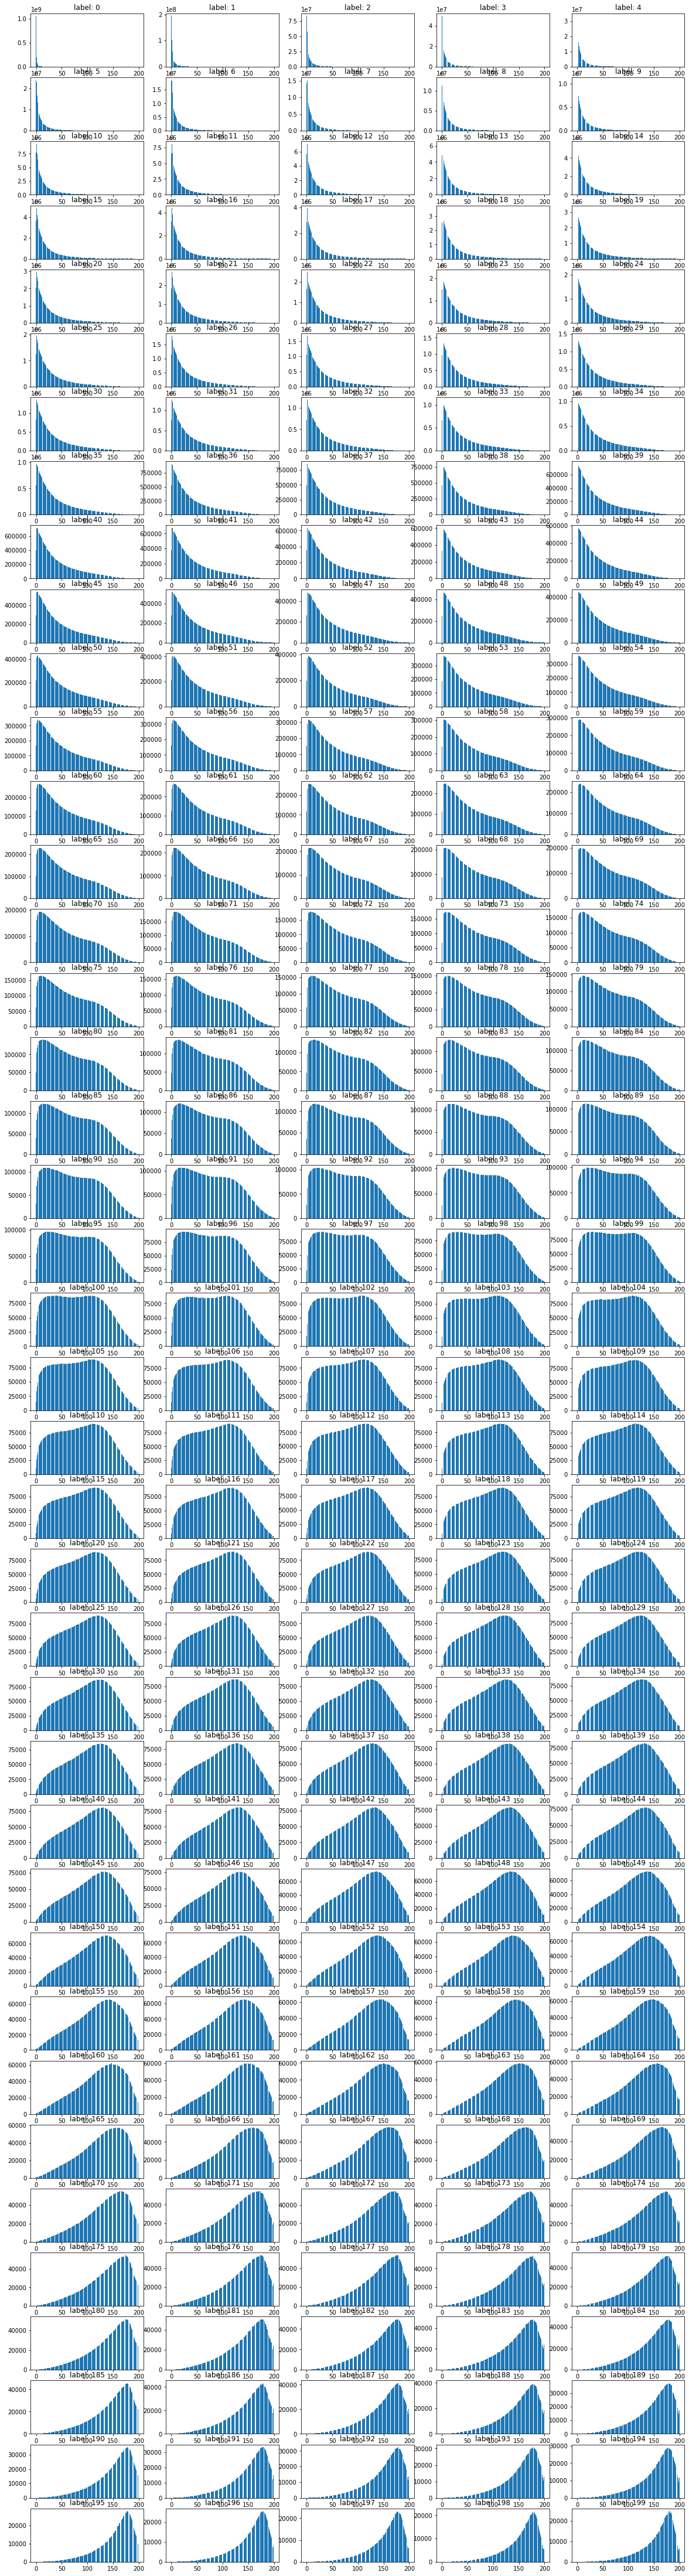

In [80]:
# distance = 10
fig, axes = plt.subplots(ncols=5, nrows=40, figsize=(20, 80))
for label in range(200):
  i = label // 5
  j = label % 5
  axes[i, j].bar(range(200), result[9][label])
  axes[i, j].set_title(f"label: {label}")

In [81]:
prob_cond = np.zeros(shape=(10, 200, 200))
for i in range(200):
  prob_cond[:, :, i] = result[:, :, i] / np.sum(result, axis=2)

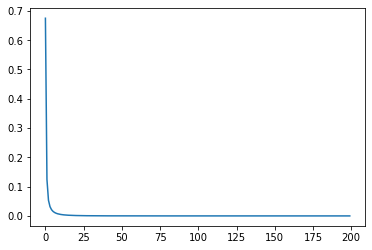

In [87]:
plt.plot(prob_cond[9, 0])

In [88]:
x = np.linspace(25, 5000, 200) - 12
mu = (x * prob_cond[9, 0]).sum()
std = np.sqrt(((x-mu)**2 * prob_cond[9,0]).sum())
print(mu, std)

56.39838959001774 144.9922642646664


In [89]:
with open("./prob_cond.txt", "w") as f:
  f.write("double prob_cond[10][201][201] = {\n")
  for i in range(10):
    f.write("  {\n")
    for j in range(200):
      f.write("    {")
      for k in range(200):
        f.write(f"{prob_cond[i, j, k]},")
      f.write("},\n")
    f.write("  },\n")
  f.write("};\n")


# pre distribution

In [14]:
pre = []
with open("out/all5000/cnt_stiff.txt", "r") as f:
  s = f.readlines()
  for line in s:
    line = int(line.strip())
    pre.append(line)

pre

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9910390,
 6583132,
 3959745,
 2984612,
 2445349,
 2095296,
 1843410,
 1656208,
 1507685,
 1386530,
 1287084,
 1201315,
 1126713,
 1063071,
 1006110,
 957091,
 912524,
 873543,
 836946,
 805077,
 775950,
 747385,
 723444,
 700427,
 679605,
 658702,
 641770,
 626324,
 610184,
 595705,
 581385,
 568058,
 556194,
 543092,
 532735,
 522504,
 511616,
 501641,
 492333,
 484265,
 476768,
 467537,
 460529,
 453026,
 447253,
 437978,
 431153,
 425629,
 420433,
 413535,
 408178,
 403902,
 398363,
 393350,
 388351,
 382315,
 378881,
 374110,
 369857,
 364752,
 359958,
 356147,
 353053,
 348941,
 345277,
 342354,
 338335,
 333278,
 331031,
 328508,
 325093,
 321904,
 318292,
 315400,
 312027,
 308853,
 306233,
 303973,
 300945,
 297259,
 295735,
 293687,
 290644,
 287303,
 285502,
 283378,
 281734,
 278643,
 276414,
 274925,
 272295,
 270369,
 267384,
 265336,
 263866,
 262177,
 260206,
 257498,
 256730,
 254747,
 252645,
 251078,
 250172,
 246909,
 245228,


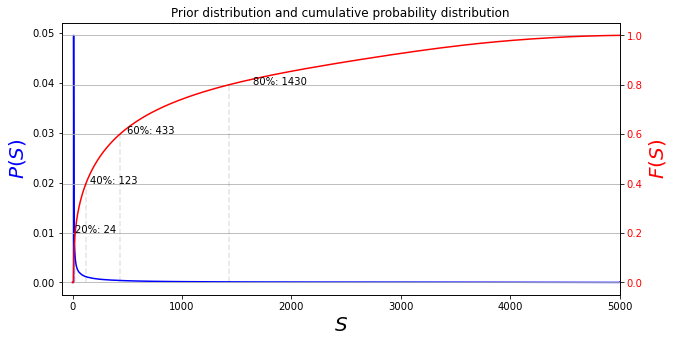

In [46]:
pre_prob = np.array(pre)
pre_prob = pre_prob / np.sum(pre_prob)
pre_prob_cum = np.array(list(accumulate(pre_prob)))
x = np.arange(5001)
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

# それぞれのaxesオブジェクトにグラフをプロット
ax1.plot(x, pre_prob, color='blue')
ax2.plot(x, pre_prob_cum, color='red')

# 2つ目のaxesオブジェクトのy軸を別のスケールに設定
# ax2.set_ylim([0, 1])

# 2つ目のaxesオブジェクトのy軸を表示
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.label.set_color('red')
ax2.grid(True)

# x軸とy軸のラベルを設定
ax1.set_xlabel('$S$', fontsize=20)
ax1.set_ylabel('$P(S)}$', color='blue', fontsize=20)
ax2.set_ylabel('$F(S)$', color='red', fontsize=20)
plt.title("Prior distribution and cumulative probability distribution")
plt.annotate('20%: 24', xy=(26, 0.2))
plt.annotate('40%: 123', xy=(160, 0.4))
plt.annotate('60%: 433', xy=(500, 0.6))
plt.annotate('80%: 1430', xy=(1650, 0.8))

plt.vlines(x=24, ymin=0, ymax=pre_prob_cum[24], colors='blue', linestyles='dashed', alpha=0.1)
plt.vlines(x=123, ymin=0, ymax=pre_prob_cum[123], colors='black', linestyles='dashed', alpha=0.1)
plt.vlines(x=433, ymin=0, ymax=pre_prob_cum[433], colors='black', linestyles='dashed', alpha=0.1)
plt.vlines(x=1430, ymin=0, ymax=pre_prob_cum[1430], colors='black', linestyles='dashed', alpha=0.1)
plt.xlim(-100, 5000)
# グラフを表示
plt.show()

In [130]:
(128 + 128) * 400

102400

In [132]:
pre_prob_cum[128]

0.4066636350000001

In [10]:
idx = 24
xx = x[idx:]
yy = pre_prob[idx:]
yy = yy / yy.sum()

mu = (xx * yy).sum()
std = np.sqrt(((xx-mu)**2 * yy).sum())
print(mu, std)

960.043579388213 1151.172424557586


In [29]:
with open("tmp.txt", "w") as f:
  f.write("long long pre[5005] = {\n  ")
  for i in range(5001):
    f.write(f"{pre[i]},")
    if (i+1)%20==0:
      f.write("\n  ")
  f.write("};\n")

In [33]:
print(pre[-1], pre[-2], len(pre))

9647 717 5001
